# sell-in-may-and-go-away

see: https://en.wikipedia.org/wiki/Sell_in_May

"Sell in May and go away" (aka the Halloween indicator) is an investment adage warning investors to divest their stock holdings in May and wait to reinvest in November.

In [7]:
# other imports
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

# project imports
import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [8]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

In [9]:
pf.DEBUG = False

Some global data

In [10]:
symbol = '^GSPC'
#symbol = 'SPY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

Define Strategy Class

In [11]:
class Strategy(object):

    def __init__(self, symbol, capital, start, end):
        self._symbol = symbol
        self._capital = capital
        self._start = start
        self._end = end

    def _algo(self):
        self._tlog.initialize(self._capital)

        for i, row in enumerate(self._ts.itertuples()):

            date = row.Index.to_pydatetime()
            high = row.high; low = row.low; close = row.close; 
            end_flag = pf.is_last_row(self._ts, i)
            shares = 0

            # buy (at the open on first trading day in Nov)
            if (self._tlog.num_open_trades() == 0
                and row.month == 11 and row.first_dotm):
                # enter buy in trade log
                shares = self._tlog.enter_trade(date, row.open)
            # sell
            elif (self._tlog.num_open_trades() > 0
                  and row.month == 5 and row.first_dotm
                  or end_flag):
                # enter sell in trade log
                shares = self._tlog.exit_trade(date, row.open)

            if shares > 0:
                pf.DBG("{0} BUY  {1} {2} @ {3:.2f}".format(
                       date, shares, self._symbol, row.open))
            elif shares < 0:
                pf.DBG("{0} SELL {1} {2} @ {3:.2f}".format(
                       date, -shares, self._symbol, row.open))

            # record daily balance
            self._dbal.append(date, high, low, close, self._tlog.shares)

    def run(self):
        self._ts = pf.fetch_timeseries(self._symbol)
        self._ts = pf.select_tradeperiod(self._ts, self._start, self._end,
                                         use_adj=True, pad=False)
        # add calendar columns
        self._ts = pf.calendar(self._ts)
        
        self._tlog = pf.TradeLog()
        self._dbal = pf.DailyBal()
        
        self._ts, self._start = pf.finalize_timeseries(self._ts, self._start)

        self._algo()

    def get_logs(self):
        """ return DataFrames """
        self.rlog = self._tlog.get_log_raw()
        self.tlog = self._tlog.get_log()
        self.dbal = self._dbal.get_log(self.tlog)
        return self.rlog, self.tlog, self.dbal

    def get_stats(self):
        stats = pf.stats(self._ts, self.tlog, self.dbal, self._capital)
        return stats

Run Strategy

In [12]:
s = Strategy(symbol, capital, start, end)
s.run()

Retrieve log DataFrames

In [13]:
rlog, tlog, dbal = s.get_logs()
stats = s.get_stats()

In [14]:
rlog.tail()

,date,price,shares,entry_exit,symbol
179,2018-05-01,2642.96,158,exit,
180,2018-11-01,2717.58,153,entry,
181,2019-05-01,2952.33,153,exit,
182,2019-11-01,3050.72,148,entry,
183,2020-05-01,2869.09,148,exit,


In [15]:
tlog.tail()

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,symbol
87,2015-11-02,2080.76,2016-05-02,2067.17,-13.59,-2391.86,176,354635.54,
88,2016-11-01,2128.68,2017-05-01,2388.50,259.82,44429.23,171,399064.77,
89,2017-11-01,2583.21,2018-05-01,2642.96,59.75,9440.50,158,408505.27,
90,2018-11-01,2717.58,2019-05-01,2952.33,234.75,35916.75,153,444422.02,
91,2019-11-01,3050.72,2020-05-01,2869.09,-181.63,-26881.22,148,417540.80,


In [16]:
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2020-06-02,427540.80,427540.80,427540.80,0,427540.80,-
2020-06-03,427540.80,427540.80,427540.80,0,427540.80,-
2020-06-04,427540.80,427540.80,427540.80,0,427540.80,-
2020-06-05,427540.80,427540.80,427540.80,0,427540.80,-
2020-06-08,427540.80,427540.80,427540.80,0,427540.80,-


In [17]:
pf.print_full(stats)

start                                                  1927-12-30
end                                                    2020-06-08
beginning_balance                                           10000
ending_balance                                          427540.80
total_net_profit                                        417540.80
gross_profit                                            555329.27
gross_loss                                             -137788.47
profit_factor                                                4.03
return_on_initial_capital                                 4175.41
annual_return_rate                                           4.15
trading_period                           92 years 5 months 9 days
pct_time_in_market                                          48.82
total_num_trades                                               92
trades_per_year                                              1.00
num_winning_trades                                             65
num_losing

Run Benchmark, Retrieve benchmark logs, and Generate benchmark stats

In [18]:
benchmark = pf.Benchmark(symbol, capital, s._start, s._end)
benchmark.run()
benchmark.tlog, benchmark.dbal = benchmark.get_logs()
benchmark.stats = benchmark.get_stats()

1927-12-30 00:00:00 BUY  566 ^GSPC @ 17.66
2020-06-08 00:00:00 SELL 566 ^GSPC @ 3232.39


Plot Equity Curves: Strategy vs Benchmark

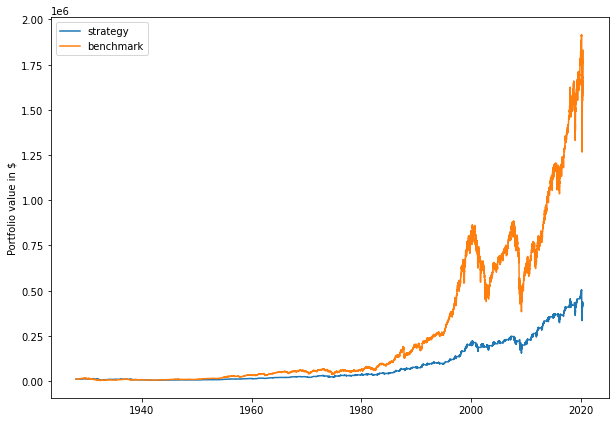

In [19]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

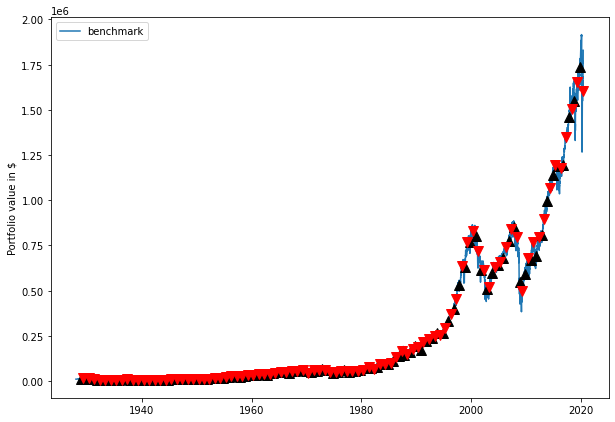

In [20]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,4.15,5.80
max_closed_out_drawdown,-71.86,-86.17
drawdown_annualized_return,-17.33,-14.86
drawdown_recovery,-12.05,-2.71
best_month,44.09,61.42
worst_month,-30.76,-42.18
sharpe_ratio,0.38,0.39
sortino_ratio,0.35,0.49
monthly_std,3.45,5.35


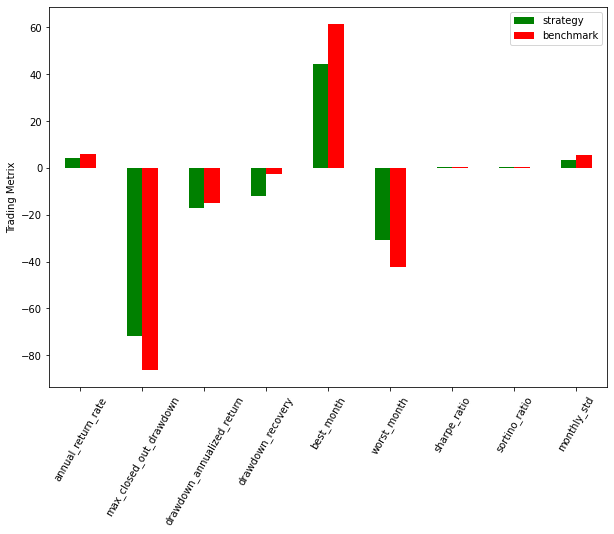

In [21]:
metrics = ('annual_return_rate',
           'max_closed_out_drawdown',
           'drawdown_annualized_return',
           'drawdown_recovery',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std')

df = pf.plot_bar_graph(stats, benchmark.stats, *metrics)
df